In [1]:
import numpy as np
import cv2 
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm
from sklearn.cluster import DBSCAN, OPTICS
import pandas as pd
from scipy.ndimage import sobel, uniform_filter1d
import scipy
import xarray as xr
import datetime
import time
from utils import *

plt.rcParams['image.origin'] = 'lower'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

In [2]:
dir = '/Users/mleclair/phd/code/dunex/data/argus'
mission_32 = 'ArgusFF_20211013T170100Z_RectifiedVideo.avi'
mission_31 = 'ArgusFF_20211013T163100Z_RectifiedVideo.avi'
mission_69 = 'ArgusFF_20211028T170100Z_RectifiedVideo.avi'
mission_59 = 'ArgusFF_20211026T160100Z_RectifiedVideo.avi'

In [426]:
file = mission_32
timestack = make_timestack(dir, file)
N, H, W, FPS = get_video_shape(os.path.join(dir, file))

1.92mb per timestack


Building Timestack:   0%|          | 0/1000 [00:00<?, ?it/s]

Building Timestack: 100%|██████████| 1000/1000 [00:01<00:00, 654.02it/s]


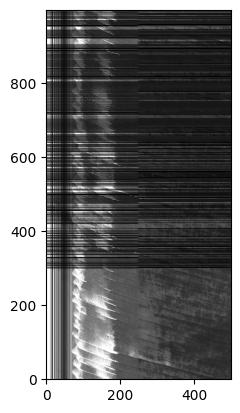

In [427]:
plt.imshow(timestack[:, 200, :])
timestack=timestack[:130]

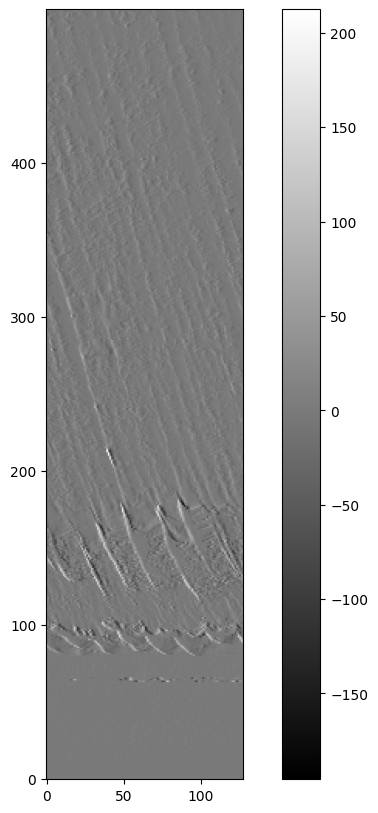

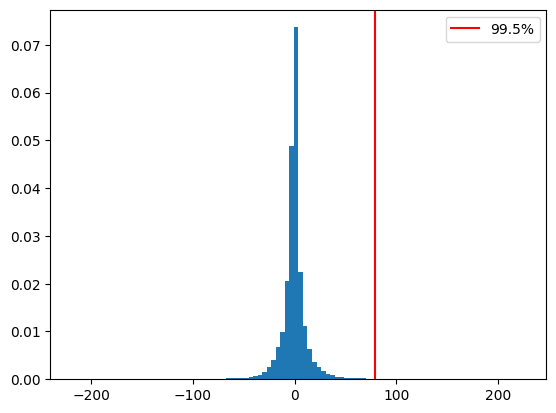

In [525]:
diff = timestack[2:] - 0.5 * ((timestack[1:-1]) + (timestack[:-2]))
# diff -= diff.mean(0)
plt.figure(figsize=(10, 10))
plt.imshow(diff[:, 500].T)
plt.colorbar()
plt.figure()
plt.hist(diff.flatten(), density=True, bins=100)
plt.axvline(np.percentile(diff.flatten(), percentile), label=f'{percentile}%', c='r')
plt.legend()

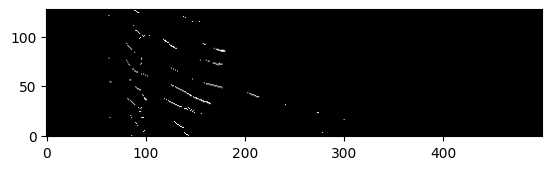

In [488]:
plt.figure()
ts = diff[:, 500]
peaks = np.zeros_like(ts)
peaks[ts > np.percentile(diff.flatten(), 99.5)] = 1
plt.imshow(peaks)

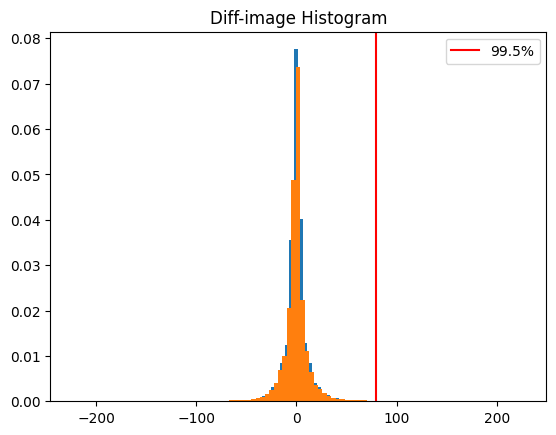

In [489]:
plt.hist((timestack[1:] - (timestack[:-1])).flatten(), bins=100, density=True)
plt.hist((timestack[2:] - 0.5 * ((timestack[1:-1]) + (timestack[:-2]))).flatten(), bins=100, density=True)
percentile = 99.5
plt.axvline(np.percentile(diff.flatten(), percentile), label=f'{percentile}%', c='r')
plt.title('Diff-image Histogram')
plt.legend()

100%|██████████| 128/128 [00:08<00:00, 15.00it/s]


(100.0, 300.0)

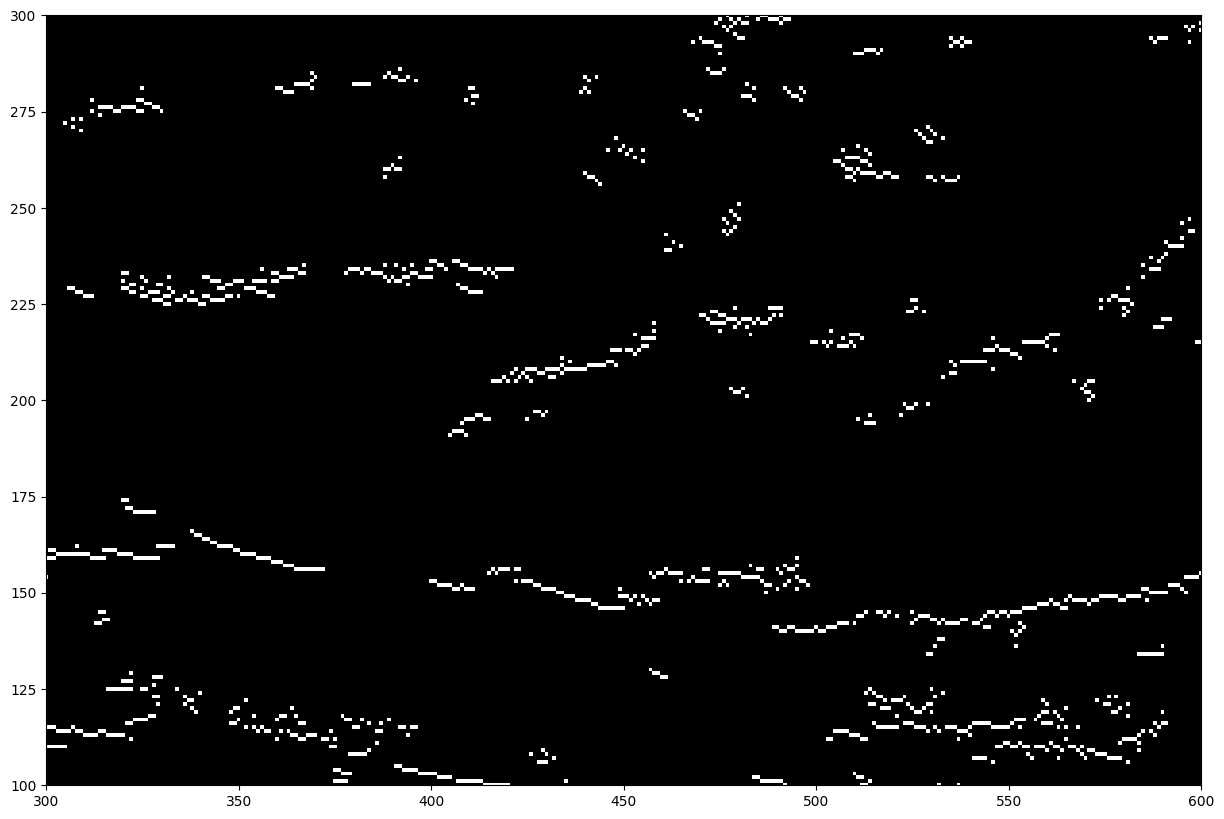

In [550]:
length = timestack.shape[0]
ts = timestack[:length]
b = np.zeros_like(ts[:length-2, :, :])
for i in tqdm(range(1600)):
    dts = ts[2:, i] - 0.5 * ((ts[1:-1, i]) + (ts[:-2, i]))

    # Threshold & take rising edge in timestack
    binary_image = detect_leading_edges(dts >= np.percentile(dts, 95), 0)
    b[:, i, :] = remove_loose_pixels_not_in_line(binary_image, min_line_length=3, eps=5, min_samples=5)
    
for i in tqdm(range(len(b))):
    # Threshold & take rising edge in space
    b[i] = detect_leading_edges(b[i], 1)
    b[i] = remove_loose_pixels_not_in_line(b[i], min_line_length=3, eps=3, min_samples=5)
    
plt.figure(figsize=(20, 10))
plt.imshow(b[1].T)
plt.xlim(300, 600)
plt.ylim(100, 300)

(100.0, 500.0)

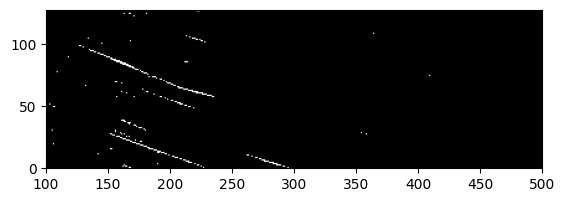

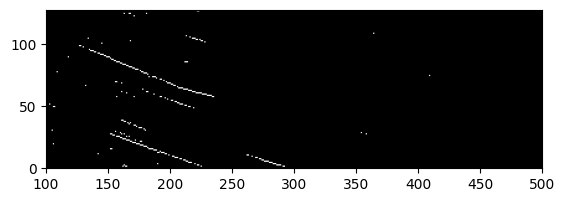

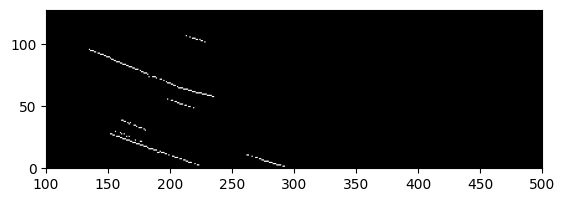

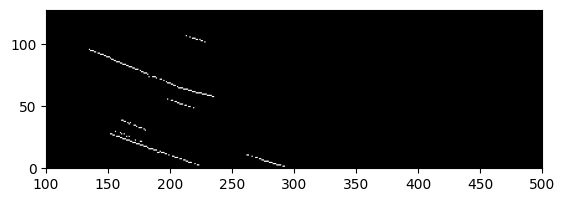

In [552]:
plt.imshow(dts > np.percentile(dts, 99.5))
plt.xlim(100, 500)
plt.figure()
plt.imshow(detect_leading_edges(dts > np.percentile(dts, 99.5), 0))
plt.xlim(100, 500)
plt.figure()
binary_image = detect_leading_edges(dts > np.percentile(dts, 99.5), 0)
plt.imshow(remove_loose_pixels_not_in_line(binary_image, min_line_length=3, eps=5, min_samples=5))
plt.xlim(100, 500)

plt.figure()
plt.imshow(remove_loose_pixels_not_in_line(binary_image, min_line_length=3, eps=5, min_samples=5))
plt.xlim(100, 500)

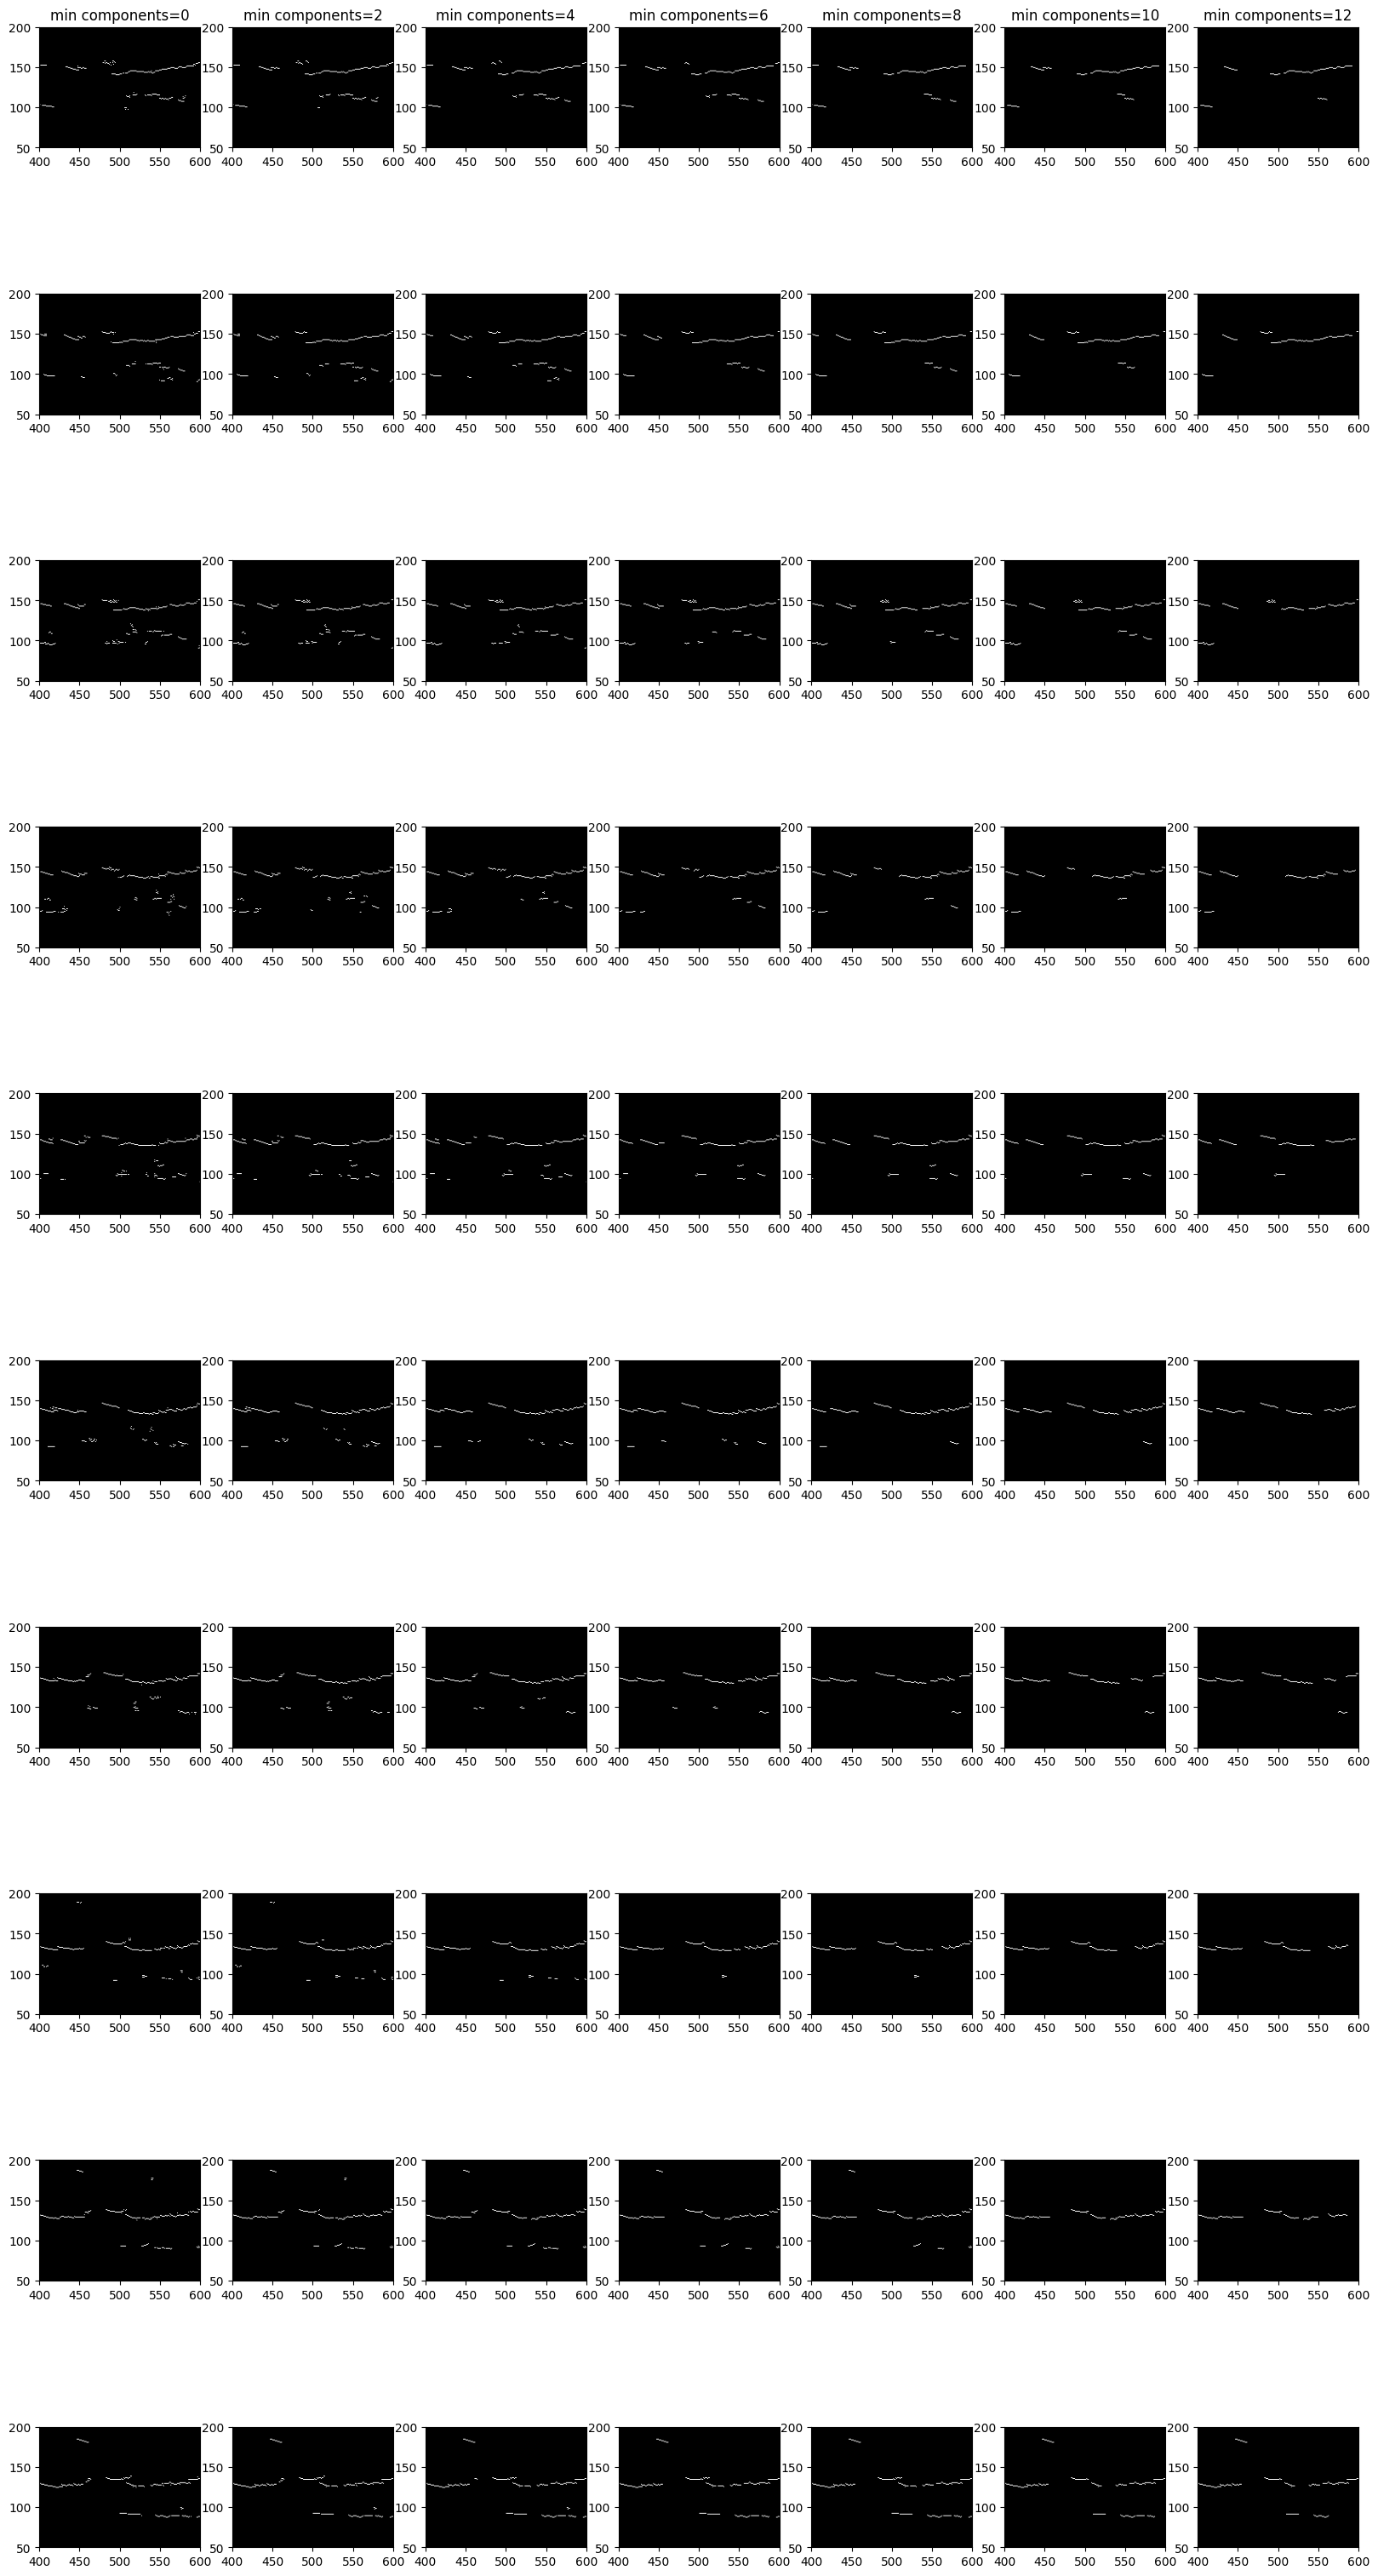

In [501]:
i = 1
fig, axs = plt.subplots(10, 7, figsize=(20, 40)) 
for j, ax in enumerate(axs):
    for k, a in enumerate(ax):
        a.imshow(
            remove_loose_pixels(b[i+j].T, 2*k)
        )
        if j == 0:
            a.set_title(f'min components={2*k}')
        a.set_xlim(400, 600)
        a.set_ylim(50, 200)
        a.set_xlim(400, 600)
        a.set_ylim(50, 200)

In [502]:
fname = '995percentile_breakers_post_filt.mp4'
out = cv2.VideoWriter(fname, cv2.VideoWriter_fourcc(*'avc1'), FPS*5, (W, H), False)

print(H, W)
for i in tqdm(range(len(b))):
    frame = remove_loose_pixels(b[i], 5).astype(np.uint8) * 255
    out.write(np.flip(np.swapaxes(frame, 0, 1), 0))
        
out.release()
cv2.destroyAllWindows()


500 1600


  0%|          | 0/128 [00:00<?, ?it/s]

100%|██████████| 128/128 [00:00<00:00, 156.27it/s]


  0%|          | 0/128 [00:00<?, ?it/s]

100%|██████████| 128/128 [00:00<00:00, 225.47it/s]


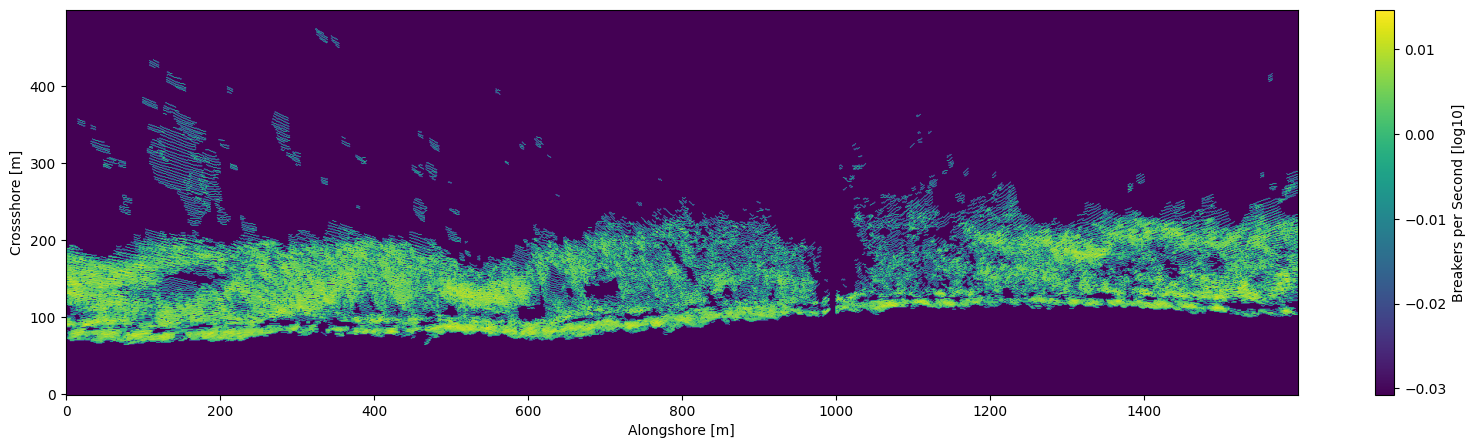

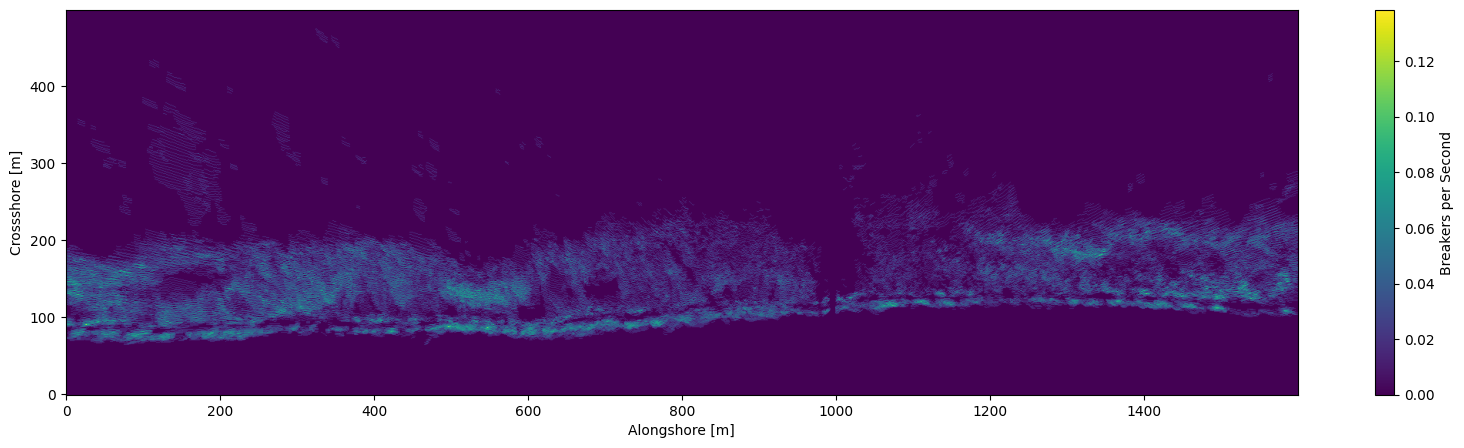

In [518]:
for i in tqdm(range(len(b))):
    b[i] = remove_loose_pixels(b[i], 5)


nb = b.sum(0)

plt.figure(figsize=(20, 5))
plt.imshow(np.log10(nb.T + 1e-2)/len(timestack)*FPS, cmap='viridis')
plt.xlabel('Alongshore [m]')
plt.ylabel('Crossshore [m]')
plt.colorbar(label='Breakers per Second [log10]')

plt.figure(figsize=(20, 5))
plt.imshow(b.sum(0).T/len(timestack)*FPS, cmap='viridis')
plt.xlabel('Alongshore [m]')
plt.ylabel('Crossshore [m]')
plt.colorbar(label='Breakers per Second')


In [436]:
# import numpy as np
# from scipy import ndimage as ndi

# def filter_and_label_spatiotemporal_propagation(binary_video, min_size=1, time_window=3, space_window=3):
#     """
#     Filter a binary video to keep only pixels that show roughly continuous propagation in space and time,
#     and label the features consistently through space and time.
    
#     Args:
#         binary_video (numpy.ndarray): A 3D binary array where dimensions are (time, height, width).
#         min_size (int): The minimum size of connected components to keep.
#         time_window (int): The number of frames to consider for temporal continuity.
#         space_window (int): The spatial window size to consider for propagation.
        
#     Returns:
#         numpy.ndarray: A 3D integer array with labeled features.
#     """
#     filtered_video = np.zeros_like(binary_video, dtype=int)
#     time_frames, height, width = binary_video.shape
    
#     # Define 3D structure element for spatiotemporal connectivity
#     s = np.ones((min(time_window, 3), 3, 3))
    
#     next_label = 1
#     label_map = {}  # Dictionary to store label correspondences between frames
    
#     for t in tqdm(range(time_frames)):
#         # Extract temporal window
#         start_t = max(0, t - time_window // 2)
#         end_t = min(time_frames, t + time_window // 2 + 1)
#         temp_window = binary_video[start_t:end_t]
        
#         # Label connected components in the temporal window
#         labels, _ = ndi.label(temp_window, structure=s)
        
#         # Get sizes of connected components
#         component_sizes = np.bincount(labels.ravel())[1:]
        
#         # Filter based on size
#         size_mask = np.zeros_like(labels)
#         size_mask[labels > 0] = (component_sizes[labels[labels > 0] - 1] >= min_size)
        
#         # Check for spatial propagation
#         prop_mask = np.zeros_like(size_mask)
#         current_frame_index = t - start_t  # Index of current frame within the window
        
#         for y in range(height):
#             for x in range(width):
#                 if size_mask[current_frame_index, y, x]:
#                     # Check neighborhood in previous and next frames if they exist
#                     has_prev = current_frame_index > 0
#                     has_next = current_frame_index < size_mask.shape[0] - 1
                    
#                     prev_neighborhood = size_mask[current_frame_index-1, 
#                                                   max(0, y-space_window//2):min(height, y+space_window//2+1),
#                                                   max(0, x-space_window//2):min(width, x+space_window//2+1)] if has_prev else np.array([])
                    
#                     next_neighborhood = size_mask[current_frame_index+1,
#                                                   max(0, y-space_window//2):min(height, y+space_window//2+1),
#                                                   max(0, x-space_window//2):min(width, x+space_window//2+1)] if has_next else np.array([])
                    
#                     # Propagation condition: either previous or next frame should have an active pixel
#                     if (np.any(prev_neighborhood) or np.any(next_neighborhood)):
#                         prop_mask[current_frame_index, y, x] = 1
        
#         # Apply both size and propagation filters
#         current_frame = size_mask[current_frame_index] & prop_mask[current_frame_index]
        
#         # Label the current frame
#         current_labels, _ = ndi.label(current_frame)
        
#         # Update labels based on previous frame
#         if t > 0:
#             prev_frame = filtered_video[t-1]
#             for label in np.unique(current_labels)[1:]:  # Skip background (0)
#                 mask = current_labels == label
#                 overlapping_labels = prev_frame[mask]
#                 non_zero_labels = overlapping_labels[overlapping_labels > 0]
#                 if len(non_zero_labels) > 0:
#                     most_common_label = np.bincount(non_zero_labels).argmax()
#                     if most_common_label in label_map:
#                         current_labels[mask] = label_map[most_common_label]
#                     else:
#                         label_map[most_common_label] = next_label
#                         current_labels[mask] = next_label
#                         next_label += 1
#                 else:
#                     # No overlap with previous frame, assign a new label
#                     current_labels[mask] = next_label
#                     next_label += 1
#         else:
#             # For the first frame, assign new labels
#             for label in np.unique(current_labels)[1:]:
#                 mask = current_labels == label
#                 current_labels[mask] = next_label
#                 next_label += 1
        
#         filtered_video[t] = current_labels
    
#     return filtered_video

import numpy as np
from scipy import ndimage as ndi
from scipy.spatial.distance import cdist

def filter_and_label_spatiotemporal_propagation(binary_video, min_size=1, time_window=3, space_window=3):
    """
    Filter a binary video to keep only pixels that show roughly continuous propagation in space and time,
    and label the features consistently through space and time.
    
    Args:
        binary_video (numpy.ndarray): A 3D binary array where dimensions are (time, height, width).
        min_size (int): The minimum size of connected components to keep.
        time_window (int): The number of frames to consider for temporal continuity.
        space_window (int): The spatial window size to consider for propagation.
        
    Returns:
        numpy.ndarray: A 3D integer array with labeled features.
    """
    filtered_video = np.zeros_like(binary_video, dtype=int)
    time_frames, height, width = binary_video.shape
    
    # Define 3D structure element for spatiotemporal connectivity
    s = np.ones((min(time_window, 3), 3, 3))
    
    next_label = 1
    feature_history = {}  # Dictionary to store feature centroids and labels
    
    for t in tqdm(range(time_frames)):
        # Extract temporal window
        start_t = max(0, t - time_window // 2)
        end_t = min(time_frames, t + time_window // 2 + 1)
        temp_window = binary_video[start_t:end_t]
        
        # Label connected components in the temporal window
        labels, _ = ndi.label(temp_window, structure=s)
        
        # Get sizes of connected components
        component_sizes = np.bincount(labels.ravel())[1:]
        
        # Filter based on size
        size_mask = np.zeros_like(labels)
        size_mask[labels > 0] = (component_sizes[labels[labels > 0] - 1] >= min_size)
        
        # Check for spatial propagation
        prop_mask = np.zeros_like(size_mask)
        current_frame_index = t - start_t  # Index of current frame within the window
        
        for y in range(height):
            for x in range(width):
                if size_mask[current_frame_index, y, x]:
                    # Check neighborhood in previous and next frames if they exist
                    has_prev = current_frame_index > 0
                    has_next = current_frame_index < size_mask.shape[0] - 1
                    
                    prev_neighborhood = size_mask[current_frame_index-1, 
                                                  max(0, y-space_window//2):min(height, y+space_window//2+1),
                                                  max(0, x-space_window//2):min(width, x+space_window//2+1)] if has_prev else np.array([])
                    
                    next_neighborhood = size_mask[current_frame_index+1,
                                                  max(0, y-space_window//2):min(height, y+space_window//2+1),
                                                  max(0, x-space_window//2):min(width, x+space_window//2+1)] if has_next else np.array([])
                    
                    # Propagation condition: either previous or next frame should have an active pixel
                    if (np.any(prev_neighborhood) or np.any(next_neighborhood)):
                        prop_mask[current_frame_index, y, x] = 1
        
        # Apply both size and propagation filters
        current_frame = size_mask[current_frame_index] & prop_mask[current_frame_index]
        
        # Label the current frame
        current_labels, num_features = ndi.label(current_frame)
        
        # Calculate centroids for current features
        current_centroids = ndi.center_of_mass(current_frame, current_labels, range(1, num_features + 1))
        
        # Create a new labeling for the current frame
        new_labeling = np.zeros_like(current_labels)
        
        if t > 0:
            # Get centroids from previous frame
            prev_centroids = [feature_history[label]['centroid'] for label in feature_history if feature_history[label]['last_frame'] == t-1]
            prev_labels = [label for label in feature_history if feature_history[label]['last_frame'] == t-1]
            
            if prev_centroids:
                # Calculate distances between current and previous centroids
                distances = cdist(current_centroids, prev_centroids)
                
                # Match current features to previous features based on minimum distance
                for i, centroid in enumerate(current_centroids):
                    if len(prev_centroids) > 0:
                        min_dist_index = np.argmin(distances[i])
                        if distances[i][min_dist_index] < space_window:
                            matched_label = prev_labels[min_dist_index]
                            mask = current_labels == i + 1
                            new_labeling[mask] = matched_label
                            feature_history[matched_label] = {'centroid': centroid, 'last_frame': t}
                            distances[:, min_dist_index] = np.inf  # Prevent this previous feature from being matched again
                        else:
                            # No close match, assign a new label
                            mask = current_labels == i + 1
                            new_labeling[mask] = next_label
                            feature_history[next_label] = {'centroid': centroid, 'last_frame': t}
                            next_label += 1
                    else:
                        # No previous features left to match, assign a new label
                        mask = current_labels == i + 1
                        new_labeling[mask] = next_label
                        feature_history[next_label] = {'centroid': centroid, 'last_frame': t}
                        next_label += 1
            else:
                # No previous features, assign new labels to all
                for i, centroid in enumerate(current_centroids):
                    mask = current_labels == i + 1
                    new_labeling[mask] = next_label
                    feature_history[next_label] = {'centroid': centroid, 'last_frame': t}
                    next_label += 1
        else:
            # First frame, assign new labels to all
            for i, centroid in enumerate(current_centroids):
                mask = current_labels == i + 1
                new_labeling[mask] = next_label
                feature_history[next_label] = {'centroid': centroid, 'last_frame': t}
                next_label += 1
        
        filtered_video[t] = new_labeling
        
        # Remove labels that haven't been used in the last 'time_window' frames
        for label in list(feature_history.keys()):
            if t - feature_history[label]['last_frame'] >= time_window:
                del feature_history[label]
    
    return filtered_video

In [437]:
breaker_labels = filter_and_label_spatiotemporal_propagation(b, 6, 10, 5)

100%|██████████| 129/129 [00:32<00:00,  3.95it/s]


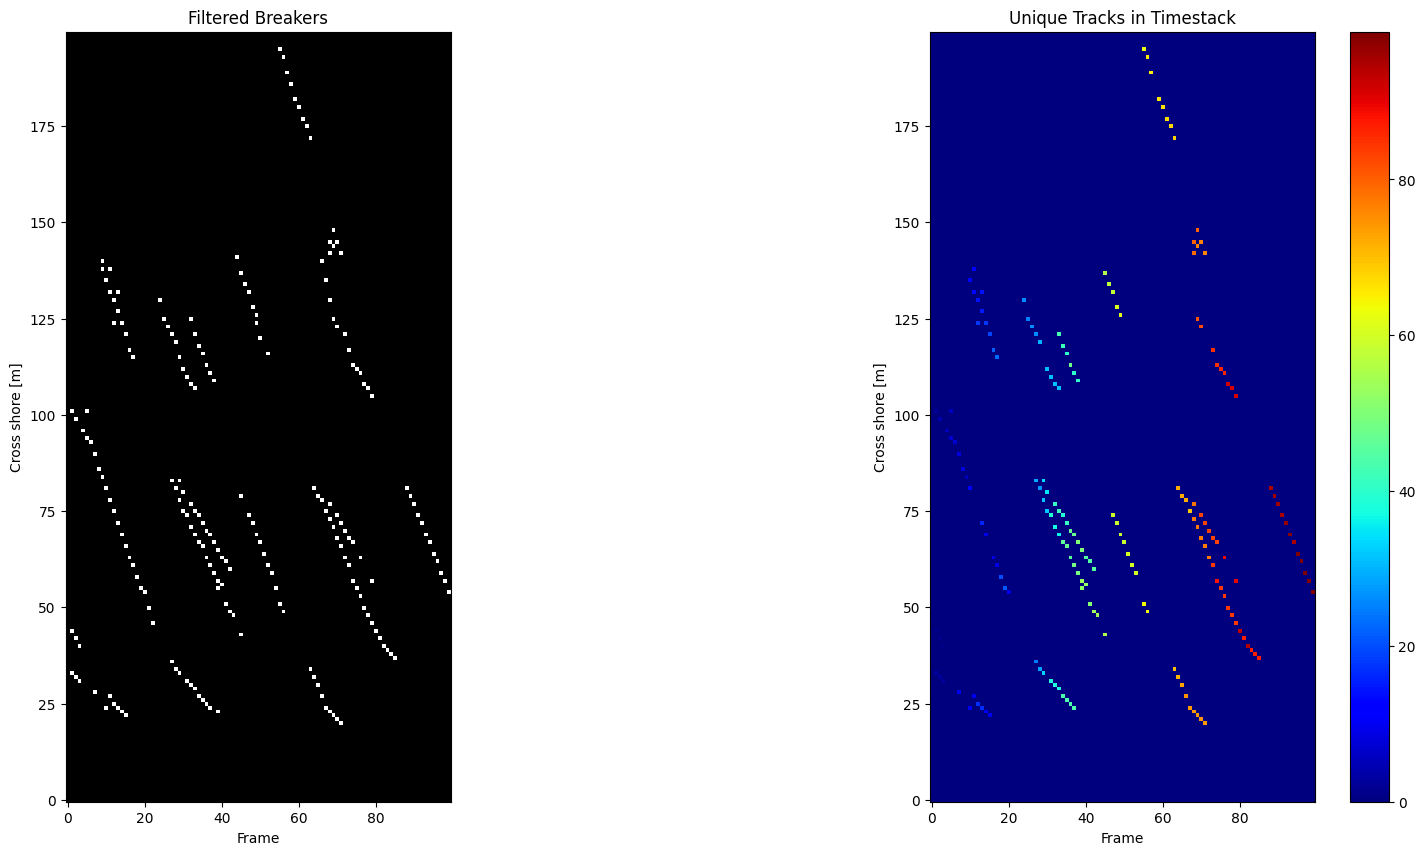

<Figure size 2000x1000 with 0 Axes>

In [438]:
# Are labels temporally consistent? NO :/
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
img = b[:100, 200, 50:250]
axs[0].set_xlabel('Frame')
axs[0].set_ylabel('Cross shore [m]')
axs[0].set_title('Filtered Breakers')
axs[0].imshow(img.T)
# axs[0].imshow(ndi.binary_erosion(ndi.binary_dilation(img, structure=np.array([[0,1,1],[0,1,0],[1,1,0]]), iterations=2), iterations=2).T)

plt.figure(figsize=(20, 10))
bk_timetack = breaker_labels[:100, 200, 50:250].T
unique_values, indices = np.unique(bk_timetack, return_inverse=True)

# Reshape indices back to the original shape of the slice
indices = indices.reshape(bk_timetack.shape)
im = axs[1].imshow(indices, cmap='jet')
axs[1].set_xlabel('Frame')
axs[1].set_ylabel('Cross shore [m]')
axs[1].set_title('Unique Tracks in Timestack')
plt.colorbar(im, ax=axs[1])

Are the things we're tracking coherent in time?

/var/folders/xv/4vxt441n3tz_yllzvqvzmsgw0000gr/T/ipykernel_82942/2384855290.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('jet', len(entity_indices))


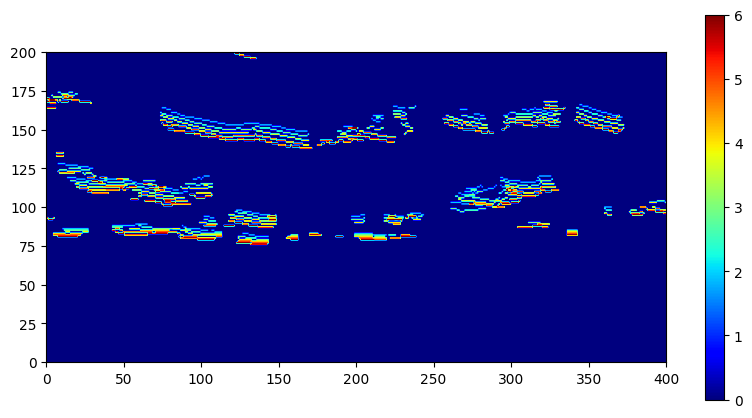

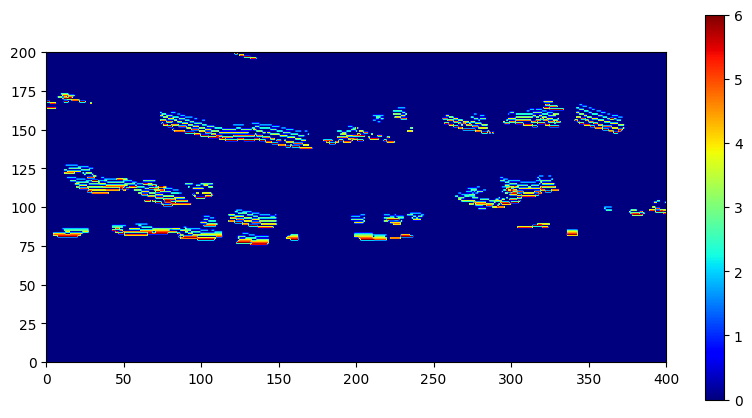

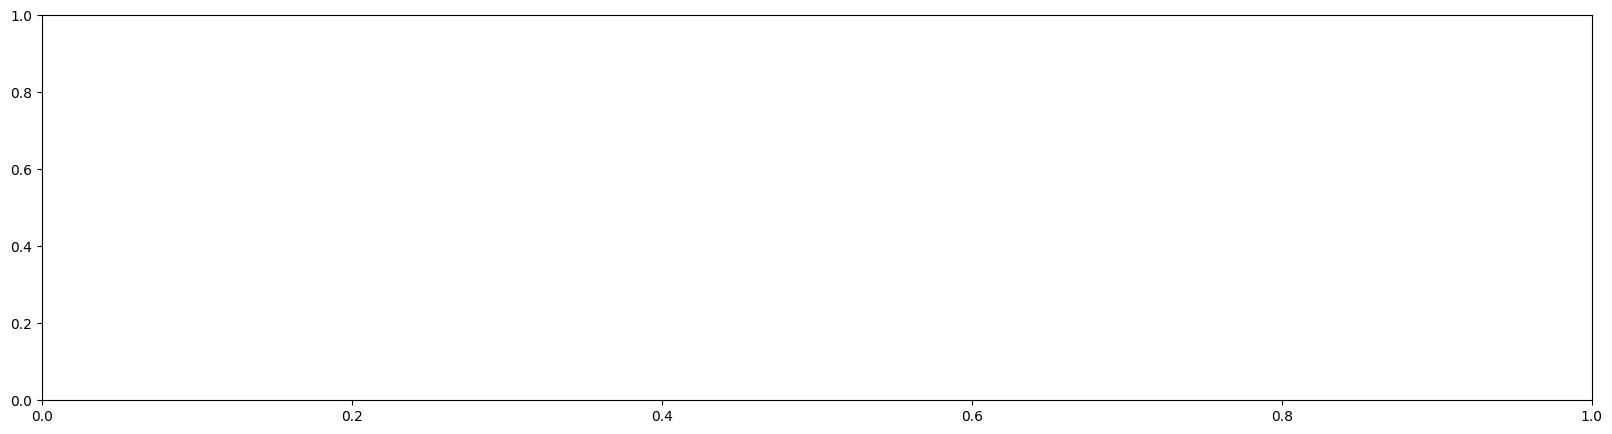

In [439]:
plt.figure(figsize=(10, 5))
plt.imshow(1*(b[0].T != 0) + 
           2*(b[1].T != 0) + 
           3*(b[2].T != 0) + 
           4*(b[3].T != 0) + 
           5*(b[4].T != 0) + 
           6*(b[5].T != 0), cmap='jet', vmin=0, vmax=6)
plt.colorbar()
plt.ylim(0, 200)
plt.xlim(0, 400)

plt.figure(figsize=(10, 5))
plt.imshow(1*(breaker_labels[0].T != 0) + 
           2*(breaker_labels[1].T != 0) + 
           3*(breaker_labels[2].T != 0) + 
           4*(breaker_labels[3].T != 0) + 
           5*(breaker_labels[4].T != 0) + 
           6*(breaker_labels[5].T != 0), cmap='jet', vmin=0, vmax=6)
plt.colorbar()
plt.ylim(0, 200)
plt.xlim(0, 400)

fig, ax = plt.subplots(figsize=(20, 5))
# Get the unique entity indices
entity_indices = np.unique(breaker_labels[:6, :400, :200])

# Create a color map with as many colors as there are unique entities
cmap = plt.cm.get_cmap('jet', len(entity_indices))
color_array = np.array([cmap(i) for i in range(len(entity_indices))])


# markers=['.', 
#          'x', 
#          '^',
#          '1',
#          '8',
#          '+',
#          's',
#          '*']

# for i, entity_index in enumerate(entity_indices):
#     if entity_index == 0:
#         continue
#     for j in range(6):
#         x, y = np.array(np.where(breaker_labels[j] == entity_index))
#         if len(x) > 0:
#             ax.scatter(x, y, color=color_array[i], label=f'Entity {entity_index}', marker=markers[j])

# plt.legend(ncol=5)

# # plt.colorbar()
# plt.ylim(0, 200)
# plt.xlim(0, 400)

Not really, the things we're tracking are kind of too fractured & small to track coherently

In [553]:
fname = '95_percentile_filtered.mp4'
out = cv2.VideoWriter(fname, cv2.VideoWriter_fourcc(*'avc1'), FPS*5, (W, H), True)
def normalize(x, scale=255):
    x = (x - x.min())
    return (x/x.max() * scale).astype(np.uint8)

print(H, W)
for i in tqdm(range(2, len(b))):
    image = normalize(timestack[i] - 0.5 * (timestack[i-1] + timestack[i-2]))
    # image = timestack[i]
    frame = np.stack((image,) * 3, axis=-1)
    if np.any(b[i]!=0):
        frame[
            # ndi.binary_dilation(
                b[i-1]!=0
                # )
            ] = np.array([0, 0, 255])
    # frame[image>np.percentile(image, 99.5)] = np.array([255, 0, 0])
    if np.any(breaker_labels[i]!=0):
        frame[
            ndi.binary_dilation(
                breaker_labels[i]!=0
            )
            ] = np.array([255, 0, 0])

    out.write(np.flip(np.swapaxes(frame.astype(np.uint8), 0, 1), 0))
    # out.write(np.flip(np.swapaxes((breaker_labels[i]!=0).astype(np.uint8) * 255, 0, 1), 0))
        
out.release()
cv2.destroyAllWindows()


500 1600


  0%|          | 0/126 [00:00<?, ?it/s]

100%|██████████| 126/126 [00:03<00:00, 38.71it/s]


In [209]:
# New idea, ransac the timestacks which look decent

import numpy as np
import matplotlib.pyplot as plt
from skimage import measure
from skimage.transform import probabilistic_hough_line
from skimage.measure import ransac
from skimage.measure import LineModelND

# Assuming 'b' is your binary image
img = b[:200, 200, :]
lines = probabilistic_hough_line(img, threshold=2, line_length=4, line_gap=9)

# Extract points from the detected lines
points = np.concatenate([np.array(line) for line in lines])


nope
nope
nope
nope
nope
nope


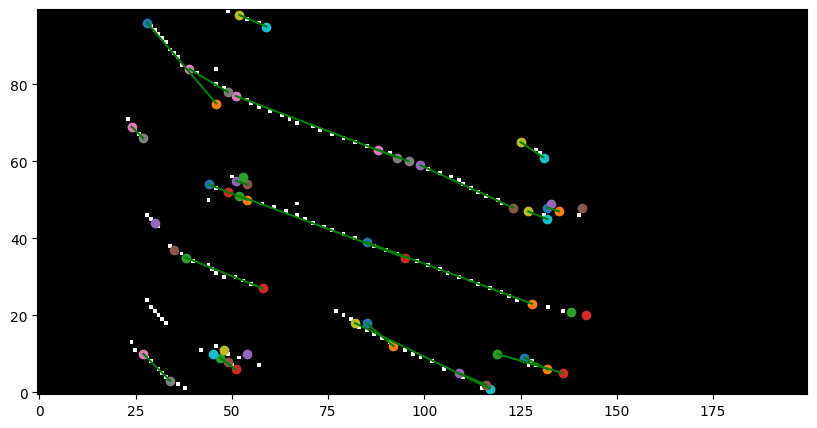

In [425]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import probabilistic_hough_line
from skimage.measure import ransac, LineModelND

plt.figure(figsize=(20, 5))

# Assuming 'b' is your binary image
lines = probabilistic_hough_line(img, threshold=2, line_length=3, line_gap=9)

# Plot the original binary image
plt.imshow(img, cmap='gray')

# Function to calculate direction vector
def calculate_direction(start, end):
    return (end - start) / np.linalg.norm(end - start)

# Store direction vectors
direction_vectors = []
robust_models = []

for line in lines:
    # Extract start and end points of the line
    start, end = np.array(line)
    
    # Fit a line model using RANSAC
    model_robust, inliers = ransac(np.array([start, end]), LineModelND, min_samples=2, residual_threshold=0.5, max_trials=1000)
    
    if model_robust is not None:
        # Calculate and store the direction vector
        direction = calculate_direction(start, end)
        direction_vectors.append(direction)
        robust_models.append((model_robust, start, end))
    plt.scatter(*start)
    plt.scatter(*end)
    



# Convert list to numpy array for vectorized operations
direction_vectors = np.array(direction_vectors)

# Calculate the mean direction vector
mean_direction = np.mean(direction_vectors, axis=0)
mean_direction /= np.linalg.norm(mean_direction)


# Tolerance for deviation (e.g., cos(angle) deviation)
tolerance = 0.95  # Corresponds to roughly ±18 degrees

for i, (model_robust, start, end) in enumerate(robust_models):
    # Calculate the cosine of the angle between the line's direction and the mean direction
    cos_angle = np.dot(direction_vectors[i], mean_direction)
    
    # Discard lines that deviate too much from the mean direction
    if cos_angle >= tolerance:
        # Get the coordinates for plotting the line only between the start and end points
        x = np.array([start[0], end[0]])
        
        try:
            y = model_robust.predict_y(x)
        except ValueError:
            # If the line is vertical, handle it by using the y-values directly
            y = np.array([start[1], end[1]])
            x = np.array([start[0], end[0]])
        
        # Plot the RANSAC fitted line
        plt.plot(x, y, '-g')

    else:
        print('nope')
plt.show()
